In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import scipy
from scipy.optimize import minimize

import pickle
import ipywidgets as widgets


In [2]:
from modules.utils import to_latex_table

In [3]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)
    
with open('..//data//men_hours_empirical', 'rb') as f:
    men_hours = pickle.load(f)
    
with open('..//data//women_salary_mean.pkl', 'rb') as f:
    women_salary = pickle.load(f)
    
with open('..//data//men_salary_mean.pkl', 'rb') as f:
    men_salary = pickle.load(f)
    
with open('..//data//fertility.pkl', 'rb') as f:
    fertility = pickle.load(f)

In [4]:
class SalaryProcess:
    
    S_min = 120
    PARAMETERS = {
        'sigma_epsilon'  : 0.15,
        'alpha' :1.2,
        'eta_G'  : 1.2,
        'eta_Z'  : 1.2,
        'eta_G_sq': 0.1,
        'delta'  : 0.9,
    }
    
    def __init__(self, Z=0, G=2, Q=18, sex='women', parameters = PARAMETERS):
        self.Z = Z
        self.G = G
        self.Q = Q
        self.sex = sex
        self.parameters = parameters
        self.Z_hist = list()
        
    def reset(self):
        self.Q = 18
        self.G = 2
        self.Z = 0
        
        # temp
        self.Z_hist.append(self.Z)

        
    def step(self):
        
        H = self.H() 
        if self.Q == 70:
            self.reset()
            H = self.H() 
            
        else:
            
            self.Q = self.Q + 1
            H = self.H() 

            self.G = self.parameters['delta'] * self.G + H / 37
            self.Z = self.Z + np.random.normal(0, self.parameters['sigma_epsilon'])
            
            # temp
            self.Z_hist.append(self.Z)
            
        S = self.calc_salary()
        return (S, self.Z, self.G, self.Q, H)
            
    def H(self):
        if self.sex=='women':
            if 18 < self.Q < 43:
                p = fertility[self.Q]
                dummy = np.random.binomial(1, p)
                if dummy == 1:
                    return 0.0
        
            return women_hours[self.Q]
        
        elif self.sex=='men':
            return men_hours[self.Q]
        else:
            raise Exception('sex must be either "women" or "men"')
        
    def calc_salary(self):
        log_S_tilde = self.parameters['alpha'] + self.parameters['eta_G'] * self.G + self.parameters['eta_G_sq'] * self.G**2 
        
        
        S_tilde = np.exp(log_S_tilde)
        S = np.max([S_tilde + self.Z, self.S_min])
        if pd.isnull(S):
            print(S_tilde, log_S_tilde, S)
        return S

In [5]:
def plot_salary_process(delta=0.9, alpha=2.3, sigma_epsilon=0.00001, eta_G=0.8, eta_G_sq= 0.1, sex='women'):
    parameters = {
        'delta': delta,
        'alpha': alpha,
        'sigma_epsilon': sigma_epsilon,
        'eta_G': eta_G,
        'eta_G_sq': eta_G_sq,
    }
    
    sp = SalaryProcess(parameters = parameters, sex=sex)
    results = list()

    for _ in range((70-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    
    hours_pred = np.array(df.groupby('Q').mean()['H'])

    y_pred = np.array(df.groupby('Q').mean()['S'])
    y_pred_90 = np.array(df.groupby('Q').quantile(0.90)['S'])
    y_pred_75 = np.array(df.groupby('Q').quantile(0.75)['S'])
    y_pred_25 = np.array(df.groupby('Q').quantile(0.25)['S'])
    y_pred_10= np.array(df.groupby('Q').quantile(0.10)['S'])
    
    y_pred = y_pred[0:66-18]
    y_pred_90 = y_pred_90[0:66-18]
    y_pred_75 = y_pred_75[0:66-18]
    y_pred_25 = y_pred_25[0:66-18]
    y_pred_10 = y_pred_10[0:66-18]

    
    size_const = 0.6
    f, ax = plt.subplots(1,1, figsize=(size_const*14, size_const*8))
    ax.plot(range(18,66),y_pred, label=f'predicted {sex}')
    ax.fill_between(range(18,66), y_pred_90, y_pred_10, color='C0', alpha=0.25)
    ax.fill_between(range(18,66), y_pred_75, y_pred_25, color='C0', alpha=0.25)


    if sex == 'women':
        ax.plot(range(18,66), women_salary[18:66], label=f'true {sex}')
        
    if sex == 'men':
        ax.plot(range(18,66), men_salary[18:66], label=f'true {sex}')
        
    ax.set_title(f'Simulated wage path for {sex}')
    ax.set_ylabel('wage DKK')
    ax.set_xlabel('age')
    
    ax.axvline(60, color='black', ls='--', label='tuning end')
    
    ax.legend()

    
    return sp, df, f

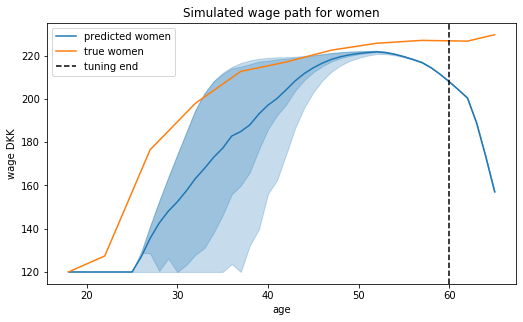

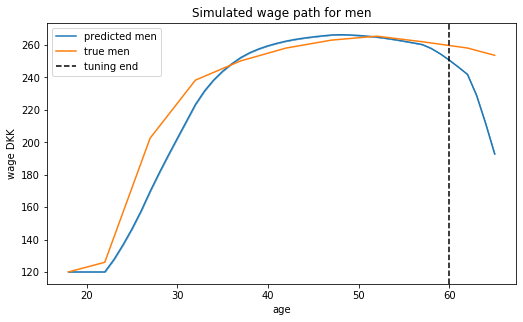

In [6]:

women_hours_, w_df, f_women = plot_salary_process(alpha=4, delta=0.7, eta_G=0.15, eta_G_sq=0.1, sex='women')
men_hours_, m_df, f_men = plot_salary_process(alpha=4, delta=0.7, eta_G=0.15,  eta_G_sq=0.1, sex='men')

In [7]:
def calc_mse(y_pred, sex='women'):
    
    
    ly_pred = len(y_pred)
    if sex == 'women':
        y_true = women_salary[18:18 + ly_pred ]
    elif sex == 'men':
        y_true = men_salary[18:18 + ly_pred ]
    else:
        raise Exception('sex must be men or women')
    
    y_pred = np.array(y_pred)
    
    ly_true = len(y_true) 
    
    ly_pred = len(y_pred)
    
    assert ly_true == ly_pred, print(ly_true, ly_pred)
    
    mse = np.mean((y_true - y_pred)**2)

    return mse
    
def calc_mae(y_pred, sex='women'):
    
    ly_pred = len(y_pred)
    if sex == 'women':
        y_true = women_salary[18:18 + ly_pred ]
    elif sex == 'men':
        y_true = men_salary[18:18 + ly_pred ]
    else:
        raise Exception('sex must be men or women')
    
    y_pred = np.array(y_pred)
    
    ly_true = len(y_true) 
    
    ly_pred = len(y_pred)
    
    assert ly_true == ly_pred, print(ly_true, ly_pred)
    
    mae = np.mean(abs(y_true - y_pred))

    return mae
    

def obj(x):
    
    np.random.seed(100)
    
    parameters = {
        'alpha' : x[0],
        'eta_G'  : x[1],
        'eta_G_sq': x[2],
        'delta'  : x[3],
        'sigma_epsilon': 0.00001
    }
    
    
    # women result
    sp = SalaryProcess(parameters = parameters)
    results = list()

    for _ in range((70-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    df = df.loc[df['Q'] < 61]
    y_pred = np.array(df.groupby('Q').mean()['S'])
    mse_women = calc_mse(y_pred, 'women')
    mae_women = calc_mae(y_pred, 'women')
    
    # men result
    sp = SalaryProcess(parameters = parameters, sex='men')
    results = list()

    for _ in range((70-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    df = df.loc[df['Q'] < 61]
    y_pred = np.array(df.groupby('Q').mean()['S'])
    mse_men = calc_mse(y_pred, 'men')
    mae_men = calc_mae(y_pred, 'men')
    
    mse = (mse_men + mse_women)/2
    parameters['mse'] = mse
    
    try:
        print(f'(MSE): men: {mse_men:.1f}, women: {mse_women:.1f}')
        print(f'(MAE): men: {mae_men:1.f}, women: {mae_women:1.f}')
        print(parameters)
    except:
        print(y_pred)
    
    return mse

In [8]:
x0 = [4, 0.15, 0.1, 0.7]
sol = minimize(obj, x0, options={'maxiter':100})


men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.0983345405498}
men: 143.2, women: 475.0 {'alpha': 4.000000014901161, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.09828539275225}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.1500000149011612, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.0981976140795}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1000000149011612, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.097950399184}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7000000149011611, 'sigma_epsilon': 1e-05, 'mse': 309.0980405571186}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.0983345405498}


/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square


men: inf, women: inf {'alpha': 4.098270510744665, 'eta_G': 0.4237830552890586, 'eta_G_sq': 0.8680866712616458, 'delta': 1.2878168173715134, 'sigma_epsilon': 1e-05, 'mse': inf}
men: inf, women: inf {'alpha': 4.098270510744665, 'eta_G': 0.4237830552890586, 'eta_G_sq': 0.8680866712616458, 'delta': 1.2878168173715134, 'sigma_epsilon': 1e-05, 'mse': inf}
men: inf, women: inf {'alpha': 4.098270525645826, 'eta_G': 0.4237830552890586, 'eta_G_sq': 0.8680866712616458, 'delta': 1.2878168173715134, 'sigma_epsilon': 1e-05, 'mse': inf}


/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


men: inf, women: inf {'alpha': 4.098270510744665, 'eta_G': 0.42378307019021977, 'eta_G_sq': 0.8680866712616458, 'delta': 1.2878168173715134, 'sigma_epsilon': 1e-05, 'mse': inf}
men: inf, women: inf {'alpha': 4.098270510744665, 'eta_G': 0.4237830552890586, 'eta_G_sq': 0.868086686162807, 'delta': 1.2878168173715134, 'sigma_epsilon': 1e-05, 'mse': inf}
men: inf, women: inf {'alpha': 4.098270510744665, 'eta_G': 0.4237830552890586, 'eta_G_sq': 0.8680866712616458, 'delta': 1.2878168322726746, 'sigma_epsilon': 1e-05, 'mse': inf}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.0983345405498}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.0983345405498}
men: 143.2, women: 475.0 {'alpha': 4.000000014901161, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'sigma_epsilon': 1e-05, 'mse': 309.09828539275225}
men: 143.2, women: 475.0 {'alpha': 4.0, 'eta_G': 

/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square


men: inf, women: inf {'alpha': 4.098270510744665, 'eta_G': 0.4237830552890586, 'eta_G_sq': 0.8680866712616458, 'delta': 1.2878168173715134, 'sigma_epsilon': 1e-05, 'mse': inf}
men: inf, women: inf {'alpha': 4.049135255372333, 'eta_G': 0.2868915276445293, 'eta_G_sq': 0.4840433356308229, 'delta': 0.9939084086857568, 'sigma_epsilon': 1e-05, 'mse': inf}
men: 509387478407318.7, women: 10241175661381.9 {'alpha': 4.024567627686166, 'eta_G': 0.21844576382226466, 'eta_G_sq': 0.2920216678154115, 'delta': 0.8469542043428784, 'sigma_epsilon': 1e-05, 'mse': 259814327034350.3}
men: 12932839.0, women: 3101701.4 {'alpha': 4.012283813843083, 'eta_G': 0.1842228819111323, 'eta_G_sq': 0.19601083390770574, 'delta': 0.7734771021714392, 'sigma_epsilon': 1e-05, 'mse': 8017270.198446948}
men: 736227.1, women: 230021.2 {'alpha': 4.008189208217826, 'eta_G': 0.17281525179104965, 'eta_G_sq': 0.16400721470392604, 'delta': 0.7489847287341617, 'sigma_epsilon': 1e-05, 'mse': 483124.1138044502}
men: 89918.1, women: 300

men: 1330.3, women: 885.3 {'alpha': 4.133868210669968, 'eta_G': 0.25814013209988595, 'eta_G_sq': 0.015826507999675915, 'delta': 0.7501103276834513, 'sigma_epsilon': 1e-05, 'mse': 1107.804505463524}
men: 1330.3, women: 885.3 {'alpha': 4.133868210669968, 'eta_G': 0.25814013209988595, 'eta_G_sq': 0.01582649309851472, 'delta': 0.7501103425846125, 'sigma_epsilon': 1e-05, 'mse': 1107.8059252605653}
men: 77.0, women: 242.5 {'alpha': 4.0677533339165635, 'eta_G': 0.21444719411686128, 'eta_G_sq': 0.07198552308373123, 'delta': 0.7057120478427226, 'sigma_epsilon': 1e-05, 'mse': 159.74460675083935}
men: 77.0, women: 242.5 {'alpha': 4.0677533339165635, 'eta_G': 0.21444719411686128, 'eta_G_sq': 0.07198552308373123, 'delta': 0.7057120478427226, 'sigma_epsilon': 1e-05, 'mse': 159.74460675083935}
men: 77.0, women: 242.5 {'alpha': 4.067753348817725, 'eta_G': 0.21444719411686128, 'eta_G_sq': 0.07198552308373123, 'delta': 0.7057120478427226, 'sigma_epsilon': 1e-05, 'mse': 159.74459654287057}
men: 77.0, wom

men: 47.1, women: 158.4 {'alpha': 4.377775356870399, 'eta_G': 0.07601502151861066, 'eta_G_sq': 0.08617423953965356, 'delta': 0.7025664701015144, 'sigma_epsilon': 1e-05, 'mse': 102.7630372450971}
men: 47.1, women: 158.4 {'alpha': 4.377775356870399, 'eta_G': 0.07601502151861066, 'eta_G_sq': 0.08617422463849236, 'delta': 0.7025664850026756, 'sigma_epsilon': 1e-05, 'mse': 102.76307441727458}
men: 50.8, women: 143.5 {'alpha': 4.444958337819539, 'eta_G': 0.03467946748975827, 'eta_G_sq': 0.09553658928167852, 'delta': 0.6983374814460308, 'sigma_epsilon': 1e-05, 'mse': 97.14383808144993}
men: 50.8, women: 143.5 {'alpha': 4.444958337819539, 'eta_G': 0.03467946748975827, 'eta_G_sq': 0.09553658928167852, 'delta': 0.6983374814460308, 'sigma_epsilon': 1e-05, 'mse': 97.14383808144993}
men: 50.8, women: 143.5 {'alpha': 4.4449583527207, 'eta_G': 0.03467946748975827, 'eta_G_sq': 0.09553658928167852, 'delta': 0.6983374814460308, 'sigma_epsilon': 1e-05, 'mse': 97.14382761819482}
men: 50.8, women: 143.5 {'

men: 46.9, women: 96.5 {'alpha': 3.3675958863690427, 'eta_G': 0.9402929958766423, 'eta_G_sq': -0.07747985517184172, 'delta': 0.6852153269412672, 'sigma_epsilon': 1e-05, 'mse': 71.67228688480432}
men: 43.5, women: 99.1 {'alpha': 3.3509621635905136, 'eta_G': 0.9498332284185368, 'eta_G_sq': -0.07836379449139183, 'delta': 0.6848134277982292, 'sigma_epsilon': 1e-05, 'mse': 71.32667946853448}
men: 43.5, women: 99.1 {'alpha': 3.3509621635905136, 'eta_G': 0.9498332284185368, 'eta_G_sq': -0.07836379449139183, 'delta': 0.6848134277982292, 'sigma_epsilon': 1e-05, 'mse': 71.32667946853448}
men: 43.5, women: 99.1 {'alpha': 3.3509621784916748, 'eta_G': 0.9498332284185368, 'eta_G_sq': -0.07836379449139183, 'delta': 0.6848134277982292, 'sigma_epsilon': 1e-05, 'mse': 71.32667741765454}
men: 43.5, women: 99.1 {'alpha': 3.3509621635905136, 'eta_G': 0.949833243319698, 'eta_G_sq': -0.07836379449139183, 'delta': 0.6848134277982292, 'sigma_epsilon': 1e-05, 'mse': 71.32667325167493}
men: 43.5, women: 99.1 {'a

men: 26.8, women: 103.8 {'alpha': 3.4061780833621778, 'eta_G': 0.843141262773299, 'eta_G_sq': -0.06302898499714998, 'delta': 0.7123233396213557, 'sigma_epsilon': 1e-05, 'mse': 65.31146925720489}
men: 26.8, women: 103.8 {'alpha': 3.4061780833621778, 'eta_G': 0.843141262773299, 'eta_G_sq': -0.06302898499714998, 'delta': 0.7123233396213557, 'sigma_epsilon': 1e-05, 'mse': 65.31146925720489}
men: 26.8, women: 103.8 {'alpha': 3.406178098263339, 'eta_G': 0.843141262773299, 'eta_G_sq': -0.06302898499714998, 'delta': 0.7123233396213557, 'sigma_epsilon': 1e-05, 'mse': 65.3114617782509}
men: 26.8, women: 103.8 {'alpha': 3.4061780833621778, 'eta_G': 0.8431412776744602, 'eta_G_sq': -0.06302898499714998, 'delta': 0.7123233396213557, 'sigma_epsilon': 1e-05, 'mse': 65.31144852163084}
men: 26.8, women: 103.8 {'alpha': 3.4061780833621778, 'eta_G': 0.843141262773299, 'eta_G_sq': -0.06302897009598879, 'delta': 0.7123233396213557, 'sigma_epsilon': 1e-05, 'mse': 65.31140981856466}
men: 26.8, women: 103.8 {'

men: 42.4, women: 70.3 {'alpha': 4.009302135751539, 'eta_G': 0.4354138695215527, 'eta_G_sq': -0.008627665208621729, 'delta': 0.7440111050544617, 'sigma_epsilon': 1e-05, 'mse': 56.349336590742546}
men: 42.4, women: 70.3 {'alpha': 4.009302135751539, 'eta_G': 0.4354138695215527, 'eta_G_sq': -0.008627665208621729, 'delta': 0.7440111050544617, 'sigma_epsilon': 1e-05, 'mse': 56.349336590742546}
men: 42.4, women: 70.3 {'alpha': 4.0093021506527, 'eta_G': 0.4354138695215527, 'eta_G_sq': -0.008627665208621729, 'delta': 0.7440111050544617, 'sigma_epsilon': 1e-05, 'mse': 56.34933387133093}
men: 42.4, women: 70.3 {'alpha': 4.009302135751539, 'eta_G': 0.4354138844227139, 'eta_G_sq': -0.008627665208621729, 'delta': 0.7440111050544617, 'sigma_epsilon': 1e-05, 'mse': 56.34932702024352}
men: 42.4, women: 70.3 {'alpha': 4.009302135751539, 'eta_G': 0.4354138695215527, 'eta_G_sq': -0.008627650307460535, 'delta': 0.7440111050544617, 'sigma_epsilon': 1e-05, 'mse': 56.34930312425314}
men: 42.4, women: 70.3 {'

men: 40.4, women: 70.7 {'alpha': 3.9811885447865447, 'eta_G': 0.4522179699372469, 'eta_G_sq': -0.014955928094986096, 'delta': 0.7549483966833178, 'sigma_epsilon': 1e-05, 'mse': 55.57221097014018}
men: 40.4, women: 70.7 {'alpha': 3.9811885447865447, 'eta_G': 0.4522179699372469, 'eta_G_sq': -0.014955928094986096, 'delta': 0.7549483966833178, 'sigma_epsilon': 1e-05, 'mse': 55.57221097014018}
men: 40.4, women: 70.7 {'alpha': 3.981188559687706, 'eta_G': 0.4522179699372469, 'eta_G_sq': -0.014955928094986096, 'delta': 0.7549483966833178, 'sigma_epsilon': 1e-05, 'mse': 55.5722109607053}
men: 40.4, women: 70.7 {'alpha': 3.9811885447865447, 'eta_G': 0.4522179848384081, 'eta_G_sq': -0.014955928094986096, 'delta': 0.7549483966833178, 'sigma_epsilon': 1e-05, 'mse': 55.572210937855985}
men: 40.4, women: 70.7 {'alpha': 3.9811885447865447, 'eta_G': 0.4522179699372469, 'eta_G_sq': -0.014955913193824902, 'delta': 0.7549483966833178, 'sigma_epsilon': 1e-05, 'mse': 55.5722108609785}
men: 40.4, women: 70.7

men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.01499099835364782, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524023988}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.01499099835364782, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524023988}
men: 40.4, women: 70.7 {'alpha': 3.98100351109408, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.01499099835364782, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240570224}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348511541384, 'eta_G_sq': -0.01499099835364782, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524154058}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990983452486626, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524539464}
men: 40.4, women: 70.7 {'

men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240239864}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240239864}
men: 40.4, women: 70.7 {'alpha': 3.98100351109408, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524057025}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348511541384, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524154057}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990983452486627, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524539458}
men: 40.4, women: 70

men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240239864}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240239864}
men: 40.4, women: 70.7 {'alpha': 3.98100351109408, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524057025}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348511541384, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524154057}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990983452486627, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524539458}
men: 40.4, women: 70

men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240239864}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.572195240239864}
men: 40.4, women: 70.7 {'alpha': 3.98100351109408, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524057025}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348511541384, 'eta_G_sq': -0.014990998353647821, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524154057}
men: 40.4, women: 70.7 {'alpha': 3.9810034961929186, 'eta_G': 0.4523348362529772, 'eta_G_sq': -0.014990983452486627, 'delta': 0.7549991763200763, 'sigma_epsilon': 1e-05, 'mse': 55.57219524539458}
men: 40.4, women: 70

In [9]:
sol
print(sol)

# old_sol5 = {'alpha': 3.7401736198159052, 'eta_G': 0.5487673463960259, 'eta_G_sq': -0.04484104545216317, 'delta': 0.8462938422559253, 'mse': 2.843191841160111}

      fun: 55.57219524024048
 hess_inv: array([[ 1.57504480e-02, -1.03256704e-02,  1.38402072e-03,
         6.72829234e-04],
       [-1.03256704e-02,  6.88270560e-03, -9.18032002e-04,
        -4.96565984e-04],
       [ 1.38402072e-03, -9.18032002e-04,  1.34944716e-04,
         2.90305214e-05],
       [ 6.72829234e-04, -4.96565984e-04,  2.90305214e-05,
         1.57643115e-04]])
      jac: array([0.02214766, 0.08725214, 0.34587812, 0.11990499])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 481
      nit: 34
     njev: 77
   status: 2
  success: False
        x: array([ 3.9810035 ,  0.45233484, -0.014991  ,  0.75499918])


In [10]:
sol_dict = {
    'alpha': sol.x[0],
    'eta_G': sol.x[1],
    'eta_G_sq': sol.x[2],
    'delta': sol.x[3]
}
sol.x

array([ 3.9810035 ,  0.45233484, -0.014991  ,  0.75499918])

In [12]:
with open('..//data//wage_path_parameters_hat.pkl', 'wb') as f:
    pickle.dump(sol_dict, f)

In [22]:
def change_name(name):
    
    if name == 'eta_G_sq':
        name = 'eta_{G^{2}}'

    return '$\hat{\{name}}$'

parameter_hat = pd.DataFrame([{change_name(key) : value for key, value in sol_dict.items()}])

In [23]:
to_latex_table('..//tables//wage_path_parameters_solved', parameter_hat, nr_decimals=3)

In [17]:
parameter_hat

,$\hat{\alpha}$,$\hat{\eta_G}$,$\hat{\eta_{G^{2}}}$,$\hat{\delta}$
0,3.981003,0.452335,-0.014991,0.754999


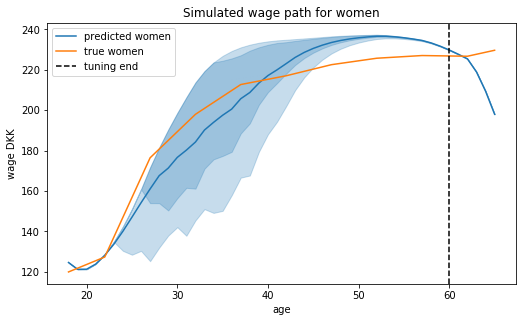

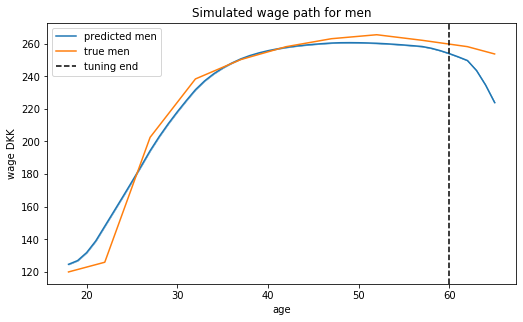

In [20]:
#old_sol2 = old_sol.copy()
#old_sol2.pop('mse')

women_hours_, _, f1 = plot_salary_process(**sol_dict, sex='women', sigma_epsilon=0.00001)
men_hours_, _ , f2 = plot_salary_process(**sol_dict, sex='men', sigma_epsilon=0.00001)

sol_dict2 = sol_dict.copy()
#sol_dict2['delta'] = 0

#sp_, _ , f = plot_salary_process(**sol_dict2, sex='men', sigma_epsilon=3)

f1.savefig('..//figures//simulated_wage_path_optimized_parameters_men')
f2.savefig('..//figures//simulated_wage_path_optimized_parameters_women')



# Tuning the wage variance